In [18]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from utils import *
from scipy.signal import find_peaks_cwt
from scipy.optimize import curve_fit as cfit

In [44]:
def gaussian(x,x0,A,s):
    return A * np.exp(-(x-x0)**2 / (2*s**2))

def slitlet(x,x1,x2,x3,A1,A2,A3,s):
    return gaussian(x,x1,A1,s) + gaussian(x,x2,A2,s) + gaussian(x,x3,A3,s)

def doTheFit(x,y,peaks):
    X = np.linspace(0,len(x),100)
    coeff, err, info, msg, ier = cfit(slitlet, x, y, p0=[*peaks,*y[peaks],0.5],full_output=True)
    print(msg)
    print(coeff)
    plt.plot(X,slitlet(X,*coeff))

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
[ 7.25242237 12.37904341 17.43584244  0.10881428  0.10906323  0.11240519
  1.65941789]


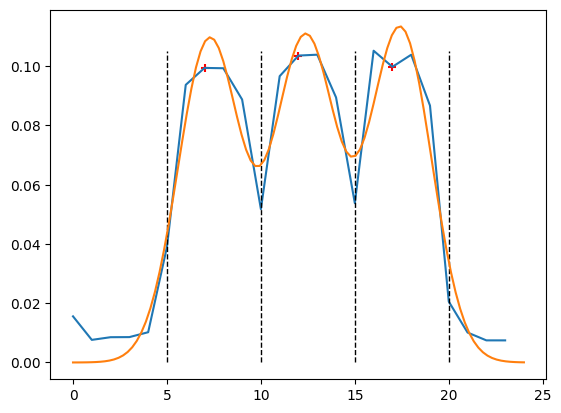

In [47]:
name = "jw01345063001_03101_00001_nrs1_srctype.fits"
multi_hdu = fits.open(name)

for i,hdu in enumerate(multi_hdu):
    if not hdu.name == 'SCI':
        continue
    hdr = hdu.header
    data = np.ma.array(hdu.data, mask=np.isnan(hdu.data))

    shutter_id = WhichShutterOpen(hdr)
    if shutter_id == None:
        continue

    # Get vertical cross section by summing horizontally
    horiz_sum = np.mean(data,axis=1)

    # Determine 3 maxima for 3 slits
    peaks = []
    j = 2
    while not len(peaks) == 3:
        if j > 6:
            break
        peaks = find_peaks_cwt(horiz_sum,j)
        j += 1
    if not len(peaks) == 3:
        continue

    peaks[1:] -=1
    
    # Cut horizontally at midpoint between maxima -> 3 strips
    slice_indices = getPeakSlice(peaks,0,len(horiz_sum))
    
    plt.figure()
    #horiz_sum -= horiz_sum.min()
    plt.plot(horiz_sum)
    plt.scatter(peaks,horiz_sum[peaks],marker='+',color="r")
    plt.vlines([5,10,15,20],0,horiz_sum.max(),color='k',linestyle='dashed',linewidth=1)
    
    doTheFit(range(len(horiz_sum)),horiz_sum,peaks)
    
    
    
    break
    
    # Get 2 background strips
    #TODO : Support for different height strips
    src = data[slice_indices[shutter_id][0]:slice_indices[shutter_id][1],:]
    bkg1 = data[slice_indices[shutter_id-1][0]:slice_indices[shutter_id-1][1],:]
    bkg2 = data[slice_indices[shutter_id-2][0]:slice_indices[shutter_id-2][1],:]


    # Determine non background sources : sudden spikes, high correlation with source strip -> flag pixels
    # TODO : Better background detection
    threshold = 0.3
    mask1 = bkg1 > bkg1.min() + (bkg1.max() - bkg1.min())*threshold
    mask2 = bkg2 > bkg2.min() + (bkg2.max() - bkg2.min())*threshold

    bkg1_keep = np.ma.array(bkg1,mask=mask1,fill_value=np.nan)
    bkg2_keep = np.ma.array(bkg2,mask=mask2,fill_value=np.nan)

    height = min(bkg1_keep.shape[0],bkg2_keep.shape[0])

    bkg_master = np.ma.dstack((bkg1_keep[:height,:],bkg2_keep[:height,:])).mean(axis=2)
    mask_master = np.ma.getmask(bkg_master)



    # Remove pixels + interpolate on a given strip (ignore source strip)
    non_nan = np.where(np.logical_not(mask_master))
    x = non_nan[0]
    y = non_nan[1]
    z = bkg_master[non_nan]

    interp = NNExtrapolation(np.c_[x, y], z)

    X = np.arange(bkg_master.shape[0])
    Y = np.arange(bkg_master.shape[1])
    YY,XX = np.meshgrid(Y,X)
    bkg_interp = interp(XX,YY)

    """
    plt.figure()

    plt.subplot(4,1,1)
    plt.title("Background")
    plt.imshow(bkg1[:height,:],interpolation='none',vmin=bkg1.min(),vmax=bkg1.max())
    plt.subplot(4,1,2)
    plt.title("Master Background")
    plt.imshow(bkg_master,interpolation='none',vmin=bkg1.min(),vmax=bkg1.max())
    plt.subplot(4,1,3)
    plt.title("Nearest Neighbour")
    plt.imshow(bkg_interp,interpolation='none',vmin=bkg1.min(),vmax=bkg1.max())
    plt.subplot(4,1,4)
    plt.title("Inverse Distance Weighting")
    interp = IDWExtrapolation(np.c_[x,y], z,power = 3)
    bkg_interp = interp(XX,YY)
    plt.imshow(bkg_interp,interpolation='none',vmin=bkg1.min(),vmax=bkg1.max())

    plt.savefig(str(i)+".png")
    plt.close()
    """
multi_hdu.close()
plt.show(block=False)

In [55]:
data = np.zeros((10,10))
data[:,:] = np.nan
data[2:4,:] = 1

non_nan = np.where(np.logical_not(np.isnan(data)))
print(data)
print(non_nan)

print(data[non_nan])

[[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]
(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
